In [1]:
# %matplotlib notebook
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kn, k1, k0, jn
import matplotlib.tri as tri
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import logging
logging.getLogger("FFC").setLevel(logging.WARNING)
dolfin.parameters.reorder_dofs_serial = False

In [2]:
#This block of code allows for plotting FEniCS objects with the Matplotlib backend.
#Credit: https://bitbucket.org/fenics-project/dolfin/issues/455/add-ipython-compatible-matplotlib-plotting

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))
# end of commands for plotting

In [17]:
d = 2
thetaS = 0.2
#THIS SECTION IS FOR MAKING THE MESH

radiusOut = 10
radiusIn = 1

Out = Circle(Point(0,0),radiusOut)
In = Circle(Point(0,0),radiusIn)

dom = Out - In

mesh = generate_mesh(dom, 150)

mesh = refine(mesh)

In [4]:
#THIS SECTION IS FOR MARKING BOUNDARIES OF THE MESH
class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - radiusOut) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - radiusIn) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
innerradius.mark(boundaries,1)
outerradius.mark(boundaries,2)

In [5]:
#This section defines the finite element basis functions
V = FunctionSpace(mesh,'Lagrange',1)
nx = TrialFunction(V)
ny = TrialFunction(V)
v1 = TestFunction(V)
v2 = TestFunction(V)

In [11]:
#This section defines the boundary conditions
gx = Expression('-x[1]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS) 
gy = Expression('x[0]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS)

#For nx
bcs1 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gx, boundaries, 1)]
#for ny
bcs2 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gy, boundaries, 1)]

In [18]:
np.linspace(2,3,1)

array([ 2.])

In [23]:
Etot_list = []
d_list = []

d_low = 2
d_high = 3
d_amt = 1

#This block solves the problem
for i in np.linspace(d_low,d_high,d_amt):
    #THIS SECTION IS FOR MARKING BOUNDARIES OF THE MESH
    class outer_boundary(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-1
            r = sqrt(x[0]*x[0] + x[1]*x[1])
            return on_boundary and abs(r - radiusOut) < tol

    class inner_boundary(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-1
            r = sqrt(x[0]*x[0] + x[1]*x[1])
            return on_boundary and abs(r - radiusIn) < tol

    outerradius = outer_boundary()
    innerradius = inner_boundary()

    boundaries = FacetFunction("size_t", mesh)

    boundaries.set_all(0)
    innerradius.mark(boundaries,1)
    outerradius.mark(boundaries,2)
    
    #This section defines the finite element basis functions
    V = FunctionSpace(mesh,'Lagrange',1)
    nx = TrialFunction(V)
    ny = TrialFunction(V)
    v1 = TestFunction(V)
    v2 = TestFunction(V)
    
    #This section defines the boundary conditions
    gx = Expression('-x[1]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS) 
    gy = Expression('x[0]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS)

    #For nx
    bcs1 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gx, boundaries, 1)]
    #for ny
    bcs2 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gy, boundaries, 1)]
    
    f = Constant(0.0)
    g = Constant(i**-2)

    a1 = (inner(nabla_grad(nx), nabla_grad(v1)) + g*(inner(nx,v1)))*dx
    a2 = (inner(nabla_grad(ny), nabla_grad(v2)) + g*(inner(ny,v2)))*dx
    L1 = f*v1*dx
    L2 = f*v2*dx
    nx = Function(V)
    ny = Function(V)
    solve(a1 == L1, nx, bcs1)
    solve(a2 == L2, ny, bcs2)

    V_d = VectorFunctionSpace(mesh,'Lagrange',1)
    w1 = TrialFunction(V_d)
    w2 = TrialFunction(V_d)
    q1 = TestFunction(V_d)
    q2 = TestFunction(V_d)

    a3 = inner(w1,q1)*dx
    a4 = inner(w2,q2)*dx
    L3 = inner(grad(nx),q1)*dx
    L4 = inner(grad(ny),q2)*dx
    grad_nx = Function(V_d)
    grad_ny = Function(V_d)
    solve(a3 == L3, grad_nx)
    solve(a4 == L4, grad_ny)

    dxnx, dynx = grad_nx.split(deepcopy=True)
    dxny, dyny = grad_ny.split(deepcopy=True)

    cell_markers = CellFunction("uint", mesh)
    dx1 = Measure("dx", domain=mesh, subdomain_data=cell_markers)

    splay = pow(dxnx+dyny,2)/2
    twist = pow(dxny-dynx,2)/2
    field = g*(pow(nx,2) + pow(ny,2))/2

    fel = splay + twist + field

    f1 = project(fel,V)

    Esplay = assemble(splay*dx1)
    Etwist = assemble(twist*dx1)
    Efield = assemble(field*dx1)

    Etot = Esplay + Etwist + Efield
    
    Etot_list.append(Etot)
    d_list.append(i)

In [9]:
def int_f(d,theta_s,K,R):
    return K*R*np.pi*theta_s**2*k0(R/d)/(d*k1(R/d))
Eint_list = int_f(np.array(d_list),0.2,1,1)

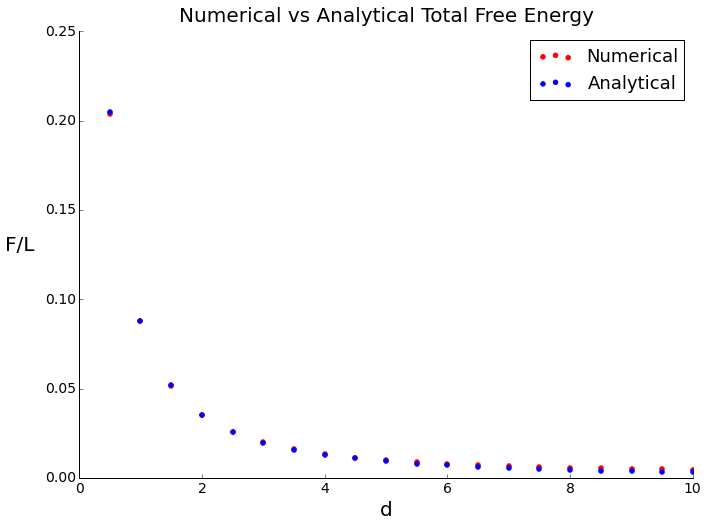

In [10]:
plt.figure(figsize=(11,8))
plt.scatter(np.array(d_list),np.array(Etot_list),color='r',label='Numerical')
plt.scatter(np.array(d_list),np.array(Eint_list),color='b',label='Analytical')
plt.legend(loc='upper right',fontsize=18)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('d',fontsize=20)
plt.ylabel('F/L',fontsize=20,labelpad=25,rotation='horizontal')
plt.title('Numerical vs Analytical Total Free Energy',fontsize=20,y=1.01)
plt.tick_params(axis='both',which='major',labelsize=14)
plt.tick_params(axis='x', top='off')
plt.tick_params(axis='y', right='off')
plt.xlim(0,10),plt.ylim(0,0.25);

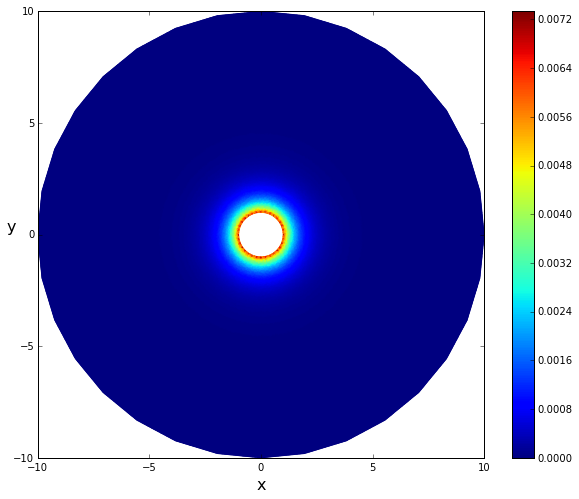

In [24]:
plt.figure(figsize=(10,10))
plot(f1)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16,rotation='horizontal',labelpad=3)
plt.colorbar(shrink=0.8);